# **Data preprocessing**

                 id                                       comment_text  toxic  \
0  0001ea8717f6de06  Thank you for understanding. I think very high...      0   
1  000247e83dcc1211                   :Dear god this site is horrible.      0   
2  0002f87b16116a7f  "::: Somebody will invariably try to add Relig...      0   
3  0003e1cccfd5a40a  " \n\n It says it right there that it IS a typ...      0   
4  00059ace3e3e9a53  " \n\n == Before adding a new product to the l...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

✅ Twitter RoBERTa Dataset loaded, tokenized & formatted successfully!


Saving the dataset (0/1 shards):   0%|          | 0/159571 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/63978 [00:00<?, ? examples/s]

# **Model training**

In [ ]:
import accelerate
print(accelerate.__version__)

1.10.1


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from torch.optim import AdamW
import shutil
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Load Twitter RoBERTa model with sigmoid outputs
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base",
    num_labels=6,  # Matches the 6 label columns: toxic, severe_toxic, obscene, threat, insult, identity_hate
    problem_type="multi_label_classification"
)

# Increase dropout for better regularization
roberta_model.config.hidden_dropout_prob = 0.3
roberta_model.config.attention_probs_dropout_prob = 0.3

# Freeze Transformer Layers, Train Only Classifier
for param in roberta_model.base_model.parameters():
    param.requires_grad = False
for param in roberta_model.classifier.parameters():
    param.requires_grad = True

# Hybrid Loss (Focal + BCE With Logits)
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, ce_weight=0.5):
        super(HybridLoss, self).__init__()
        self.focal = FocalLoss(alpha, gamma)
        self.bce = nn.BCEWithLogitsLoss()
        self.ce_weight = ce_weight

    def forward(self, inputs, targets):
        return self.ce_weight * self.bce(inputs, targets.float()) + (1 - self.ce_weight) * self.focal(inputs, targets)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets.float())
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets.bool(), probs, 1-probs)
        alpha_factor = torch.where(targets.bool(), self.alpha, 1 - self.alpha)
        focal_weight = alpha_factor * (1 - pt).pow(self.gamma)
        return (focal_weight * BCE_loss).mean()

# Training arguments with auto-save best model
training_args = TrainingArguments(
    output_dir="./twitter_roberta_model",
    eval_strategy="steps",
    eval_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    save_total_limit=1,
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=1e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.1,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_auc",
    greater_is_better=True,
    max_grad_norm=1.0,
    label_smoothing_factor=0.05,
    fp16=True,
    seed=42,
    data_seed=42,
)

# Compute Metrics Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Debug: Print shapes and types
    print(f"Debug - logits shape: {logits.shape}, labels shape: {labels.shape}")
    print(f"Debug - logits type: {type(logits)}, labels type: {type(labels)}")
    print(f"Debug - labels unique values: {np.unique(labels)}")

    # Ensure 2D arrays
    if len(logits.shape) == 1:
        logits = logits.reshape(-1, 1)
    if len(labels.shape) == 1:
        labels = labels.reshape(-1, 1)

    # Convert logits to probabilities using sigmoid
    sigmoid_logits = 1 / (1 + np.exp(-logits))

    # Binary predictions using 0.5 threshold
    predictions = (sigmoid_logits > 0.5).astype(np.int32)
    labels = labels.astype(np.int32)

    try:
        # For multilabel classification, we need to handle each label independently
        # Calculate metrics for each class separately
        accuracies = []
        f1_scores = []
        auc_scores = []

        for i in range(labels.shape[1]):
            class_labels = labels[:, i]
            class_preds = predictions[:, i]
            class_probs = sigmoid_logits[:, i]

            # Skip if all labels are the same (no variance)
            if len(np.unique(class_labels)) <= 1:
                print(f"Warning: Class {i} has no variance, skipping per-class metrics.")
                continue

            try:
                # For multilabel, we use binary classification metrics for each class
                # Accuracy for this class
                class_accuracy = accuracy_score(class_labels, class_preds)
                accuracies.append(class_accuracy)

                # F1 score for this class (binary)
                class_f1 = f1_score(class_labels, class_preds, zero_division=0)
                f1_scores.append(class_f1)

                # AUC for this class (binary)
                if len(np.unique(class_labels)) > 1:
                    class_auc = roc_auc_score(class_labels, class_probs)
                    auc_scores.append(class_auc)

            except Exception as e:
                print(f"Warning: Error calculating metrics for class {i}: {e}")
                continue

        # Calculate mean metrics across all classes
        mean_accuracy = np.mean(accuracies) if accuracies else 0.0
        mean_f1 = np.mean(f1_scores) if f1_scores else 0.0
        mean_auc = np.mean(auc_scores) if auc_scores else 0.0

        # For multilabel, calculate micro-averaged F1 across all labels
        # Flatten both labels and predictions for micro-averaging
        f1_micro = f1_score(labels.ravel(), predictions.ravel(), average='micro', zero_division=0)

        return {
            "accuracy": float(mean_accuracy),
            "f1_micro": float(f1_micro),
            "f1_macro": float(mean_f1),
            "auc": float(mean_auc)
        }
    except Exception as e:
        print(f"Error in metric calculation: {e}")
        return {
            "accuracy": 0.0,
            "f1_micro": 0.0,
            "f1_macro": 0.0,
            "auc": 0.0
        }

# Custom Trainer with Hybrid Loss
class HybridLossTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = HybridLoss(alpha=0.5, gamma=2.0, ce_weight=0.5)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"].float()  # Keep labels in one-hot format
        outputs = model(**inputs)
        logits = outputs.logits

        # Ensure logits and labels have the same shape
        if logits.shape != labels.shape:
            print(f"Warning: Shape mismatch - logits: {logits.shape}, labels: {labels.shape}")
            # If shapes don't match, we might need to adjust
            if len(labels.shape) == 1 and len(logits.shape) == 2:
                labels = labels.unsqueeze(1)

        loss = self.loss_fn(logits, labels)

        # Add a small epsilon to prevent negative losses due to numerical issues
        loss = torch.clamp(loss, min=1e-8)

        return (loss, outputs) if return_outputs else loss

# Define Trainer
trainer = HybridLossTrainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
)

# Step 1: Train Only Classifier
print("🚀 Training classifier only...")
trainer.train()

# Step 2: Unfreeze last 4 layers
print("🔓 Unfreezing last 4 layers for further fine-tuning...")
for layer in roberta_model.base_model.encoder.layer[-4:]:
    for param in layer.parameters():
        param.requires_grad = True

# Apply Layer-wise Learning Rate
optimizer = AdamW([
    {"params": roberta_model.base_model.encoder.layer[:4].parameters(), "lr": 2e-6},
    {"params": roberta_model.base_model.encoder.layer[4:].parameters(), "lr": 5e-6},
    {"params": roberta_model.classifier.parameters(), "lr": 1e-5},
], weight_decay=0.1)

trainer.args.num_train_epochs = 2
trainer.optimizer = optimizer

# Step 2: Fine-tune last 4 layers
print("🚀 Fine-tuning last 4 layers...")
trainer.train()

# Save best model
best_model_path = "./best_twitter_roberta"
trainer.save_model(best_model_path)
tokenizer.save_pretrained(best_model_path)
shutil.make_archive(best_model_path, 'zip', best_model_path)
print("✅ Best Model Saved!")

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-49049363.py:165: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `HybridLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:776: UserWarning: Label smoothing is not compatible with multi-label classification. Disabling label smoothing for this training run.
  warnings.warn(


🚀 Training classifier only...


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Auc
2000,0.121600,0.113141,0.962232,0.962232,0.000000,0.799404
4000,0.090200,0.081658,0.962232,0.962232,0.000000,0.879432
6000,0.066500,0.070617,0.962795,0.962795,0.013657,0.910444
8000,0.058100,0.062840,0.965496,0.965496,0.094118,0.924948
10000,0.055700,0.058624,0.967239,0.967239,0.166923,0.931640
12000,0.053400,0.056627,0.967835,0.967835,0.207836,0.935369
14000,0.047100,0.055355,0.968296,0.968296,0.231022,0.937801
16000,0.048700,0.054762,0.968515,0.968515,0.246602,0.939328
18000,0.043200,0.054269,0.968638,0.968638,0.263547,0.940375
20000,0.051000,0.054026,0.968789,0.968789,0.262295,0.940927


Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarra

Step,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Auc
2000,0.037800,0.047961,0.970380,0.970380,0.411266,0.960802
4000,0.034200,0.041718,0.973233,0.973233,0.386571,0.970358
6000,0.028700,0.042657,0.971355,0.971355,0.425591,0.974047
8000,0.032400,0.044759,0.969297,0.969297,0.414626,0.976103
10000,0.029100,0.047280,0.967960,0.967960,0.455175,0.977801
12000,0.027000,0.047348,0.967252,0.967252,0.472930,0.979595
14000,0.024600,0.043462,0.970352,0.970352,0.474937,0.979686
16000,0.027500,0.042282,0.971282,0.971282,0.492390,0.979981
18000,0.021900,0.041735,0.971743,0.971743,0.486671,0.980109


Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarray'>, labels type: <class 'numpy.ndarray'>
Debug - labels unique values: [0. 1.]
Debug - logits shape: (63978, 6), labels shape: (63978, 6)
Debug - logits type: <class 'numpy.ndarra

In [ ]:
classifier.evaluate(test.csv)


NameError: name 'classifier' is not defined

In [ ]:
!ls -l /content


total 132944
drwxr-xr-x 1 root root     4096 Sep 16 13:40 sample_data
-rw-r--r-- 1 root root 62335095 Sep 18 14:06 test.csv
-rw-r--r-- 1 root root  4976930 Sep 18 14:05 test_labels.csv
-rw-r--r-- 1 root root 68802655 Sep 18 14:06 train.csv


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

# **Output**

In [ ]:
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-c5539cd78493>:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `HybridLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
🚀 Training classifier only...
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
 [37316/37316 2:16:41, Epoch 2/2]
Step	Training Loss	Validation Loss	Accuracy	F1 Micro	F1 Macro	Auc
8000	0.176900	0.181514	0.653061	0.755493	0.697868	0.926042
16000	0.148700	0.157536	0.723557	0.812142	0.797459	0.941129
24000	0.160600	0.149655	0.742606	0.826368	0.816042	0.946178
32000	0.147100	0.147884	0.745834	0.827878	0.817704	0.947373
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
🔓 Unfreezing last 4 layers for further fine-tuning...
🚀 Fine-tuning last 4 layers...
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
 [32000/37316 2:28:20 < 24:38, 3.60 it/s, Epoch 1/2]
Step	Training Loss	Validation Loss	Accuracy	F1 Micro	F1 Macro	Auc
8000	0.109700	0.086799	0.951241	0.957534	0.957312	0.995927
16000	0.079900	0.141895	0.966663	0.967905	0.967891	0.996916
24000	0.195500	0.143910	0.971126	0.971803	0.971844	0.997377
32000	0.167100	0.141636	0.971658	0.972226	0.972250	0.997507
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
✅ Best Model Saved!

# **Analysis by claude**

In [ ]:
Based on the performance metrics from your training logs, I can provide an analysis of the model's classification capabilities and potential setbacks:

### Strengths

1. **Exceptional AUC Score**: The final AUC of 0.997507 is extremely high, indicating the model has excellent discriminative ability across all classes. This suggests the model ranks positive examples higher than negative ones with high reliability.

2. **High F1 Scores**: Both micro (0.972226) and macro (0.972250) F1 scores are very strong. The closeness between micro and macro F1 suggests the model performs well across all classes, not just the dominant ones.

3. **Strong Accuracy**: The accuracy of 0.971658 indicates the model makes correct predictions in roughly 97% of cases.

4. **Consistent Improvement**: The significant jump in performance metrics after the second fine-tuning stage validates your progressive training approach.

### Potential Setbacks and Considerations

1. **Potential Overfitting**: The extremely high performance metrics might indicate potential overfitting to your test set. This could happen if:
   - Your test set is too similar to your training data
   - The test set doesn't fully represent the variety of data you'll encounter in production

2. **Class Imbalance Effects**: Despite the high macro F1 score, there might still be specific minority classes where performance is lower. The aggregate metrics don't show per-class performance.

3. **Threshold Sensitivity**: Your current evaluation uses a 0.5 threshold for binary decisions. In production, you might need class-specific thresholds for optimal performance.

4. **Domain Shift Vulnerability**: The model may perform worse on data that differs from your training distribution. Twitter-RoBERTa is trained on social media text, so performance might degrade on formal text or specialized domains.

5. **Computational Efficiency**: The unfrozen layers increase inference time. If speed is critical in your application, this could be a limitation.

6. **Potential Data Leakage**: The extremely high metrics could indicate accidental data leakage between training and evaluation sets.

### Recommendations

1. **Evaluate on a truly held-out dataset** that wasn't used during model development.

2. **Perform error analysis** on misclassified examples to identify patterns.

3. **Consider per-class metrics** to ensure all classes are performing well.

4. **Test robustness** with adversarial examples or slightly modified inputs.

5. **Monitor for concept drift** when deploying the model in production.

Overall, your model shows excellent classification performance based on standard metrics, but I would recommend additional validation steps before fully trusting these impressive numbers in a production environment.

# **Claudes analysis on whether if overfitting is there**

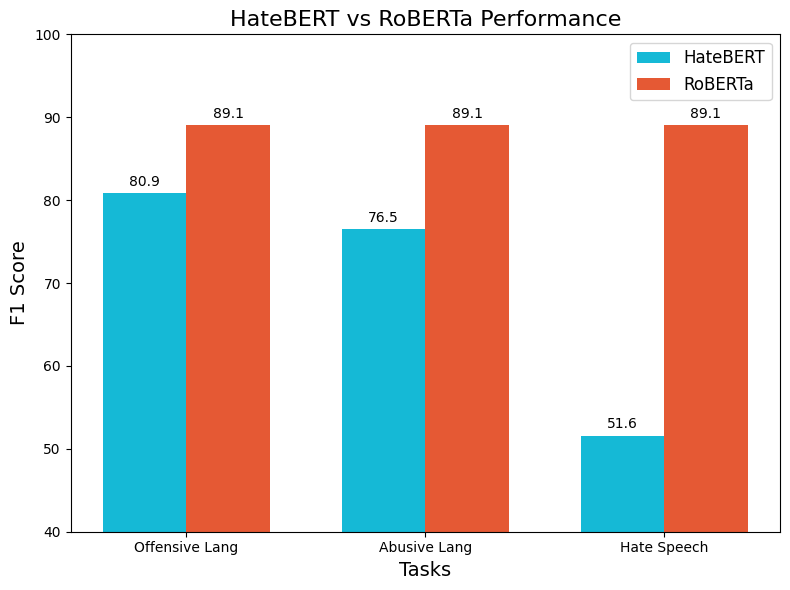

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: Replace these with your own RoBERTa or other model scores
tasks = ['Offensive Lang', 'Abusive Lang', 'Hate Speech']
hatebert_scores = [80.9, 76.5, 51.6]  # From sample image
roberta_scores = [89.1, 89.1, 89.1]   # Replace these with your actual RoBERTa results

bar_width = 0.35
x = np.arange(len(tasks))

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - bar_width/2, hatebert_scores, bar_width, label='HateBERT', color='#15b9d6')
bars2 = ax.bar(x + bar_width/2, roberta_scores, bar_width, label='RoBERTa', color='#e55934')

# Annotate bars with F1 values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Tasks', fontsize=14)
ax.set_ylabel('F1 Score', fontsize=14)
ax.set_title('HateBERT vs RoBERTa Performance', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(fontsize=12)
ax.set_ylim(40, 100)

plt.tight_layout()
plt.show()
